In [1]:
import os
import json
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm

import cv2

In [2]:
"""
Load training data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
labels list consists of ground truth masks -  numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""

# path to data directory
path = "../input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/"
path_images = os.path.join(path, 'studies/CT-1/')
path_labels = os.path.join(path, 'masks/')
with open('../input/data-jsons/training_data.json', 'r') as f:
    dict_training = json.load(f)

images = []
labels = []
for entry in tqdm(dict_training):
    image = nib.load(os.path.join(path_images, entry['image']))
    label = nib.load(os.path.join(path_labels, entry['label']))
    images.append(image.get_fdata())
    labels.append(label.get_fdata())

  0%|          | 0/40 [00:00<?, ?it/s]

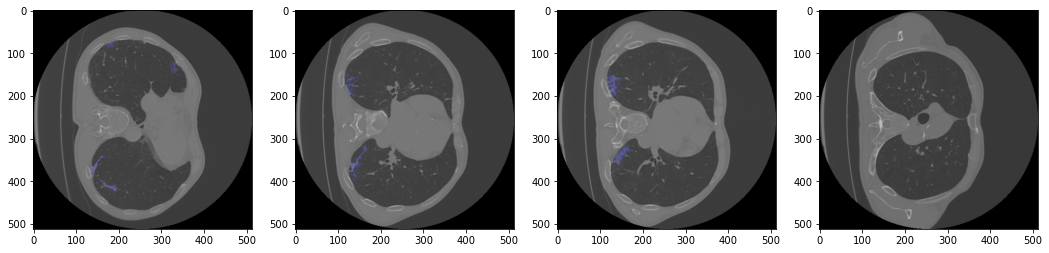

In [3]:
#Visualize some of the slices
from PIL import Image
import matplotlib.pyplot as plt

def blend(image, mask):
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

patient_num = 10
slices_num = (10, 19, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images[patient_num][..., idx],
        labels[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [4]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Activation, UpSampling2D, LeakyReLU, Multiply, Add, Average, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, Conv3D, MaxPooling3D, Dropout, BatchNormalization, concatenate
from keras.utils import to_categorical

from keras.losses import binary_crossentropy
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from tensorflow.python.keras import backend as K2

from skimage.transform import rescale

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [6]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_coef_loss(y_true, y_pred))

In [7]:
def images_reshape(images):
    forms = np.zeros(shape = (len(images)), dtype = 'uint8')
    for i in range(len(forms)):
        forms[i] = images[i].shape[2]    
    all_slices = []
    for i in range(len(forms)):
        for k in range(forms[i]):
            all_slices.append(images[i][:,:,k])
    all_slices = np.array(all_slices, dtype = 'float32')
    return forms, all_slices

def images_resize(slices, new_shape, verbose = 0):
    slices_new = []
    for i in range(len(slices)):
        slices_new.append(cv2.resize(slices[i], new_shape)) 
    if verbose == 1: print("done")
    slices_new = np.array(slices_new, dtype = 'float32')
    return slices_new


def images_upscale(images, new_shape, verbose = 0):
    images_new = []
    for num in range(len(images)):
        img = images[num]
        img_resized = np.zeros(shape = (img.shape[0], new_shape[0], new_shape[1]))
        for i in range(img_resized.shape[0]):
            img_resized[i] = cv2.resize(img[i], new_shape, interpolation = cv2.INTER_CUBIC)
        images_new.append(img_resized)
        if verbose == 1: print("#", end='')
    if verbose == 1: print("\n")
    return images_new

In [8]:
# metrics: 'dice_coef', 'acc', 'f1_m', 'precision_m', 'recall_m'

def show_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["dice_coef"], label="dice coef")
    ax[0].plot(history.epoch, history.history["val_dice_coef"], label="val dice coef")
    
    ax[1].set_title('f1_m')
    ax[1].plot(history.epoch, history.history["f1_m"], label="f1")
    ax[1].plot(history.epoch, history.history["val_f1_m"], label="val f1")
    
    ax[2].set_title('precision_m')
    ax[2].plot(history.epoch, history.history["precision_m"], label="precision")
    ax[2].plot(history.epoch, history.history["val_precision_m"], label="val precision")
    
    ax[3].set_title('recall_m')
    ax[3].plot(history.epoch, history.history["recall_m"], label="recall")
    ax[3].plot(history.epoch, history.history["val_recall_m"], label="val recall")
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

In [10]:
# g = upsample, x = block_i_out, inter_channel = down_layer_channels // 4
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding="same")(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    f = Activation("relu")(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), padding="same")(f)
    rate = Activation("sigmoid")(psi_f)
    att_x = Multiply()([x, rate])
    return att_x

def cba_block(inputs, filters):
    x = Conv2D(filters, (3, 3), kernel_initializer="he_uniform", padding="same")(inputs)
    x = BatchNormalization(fused=True, dtype=tf.float32)(x)
    return Activation("relu")(x)


def AttentionUnet(img_size, wide = False):
    input_shape = (img_size, img_size, 1)
    inputs = Input(input_shape, name = "input")
    
    if wide:
        img_size *= 2
        
    ker = "he_uniform"
    
    # Block 1
    filters = img_size // 16
    x = cba_block(inputs, filters)
    block_1_out = cba_block(x, filters)
    pool1 = MaxPooling2D(pool_size=(2, 2), name="block12_pool")(block_1_out)
    
    # Block 2
    filters = img_size // 8
    x = cba_block(pool1, filters)
    block_2_out = cba_block(x, filters)
    pool2 = MaxPooling2D(pool_size=(2, 2), name="block23_pool")(block_2_out)
    
    # Block 3
    filters = img_size // 4
    x = cba_block(pool2, filters)
    block_3_out = cba_block(x, filters)
    pool3 = MaxPooling2D(pool_size=(2, 2), name="block34_pool")(block_3_out)
    
    # Block 4
    filters = img_size // 2
    x = cba_block(pool3, filters)
    x = cba_block(x, filters)
    block_4_out = Dropout(0.4)(x)
    pool4 = MaxPooling2D(pool_size=(2, 2), name="block45_pool")(block_4_out)

    
    # Block 5
    filters = img_size
    x = cba_block(pool4, filters)
    x = cba_block(x, filters)
    x = cba_block(x, filters)
    block_5_out = Dropout(0.1)(x)
    
    
    # UP1
    filters = img_size // 2
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same", activation="relu", name="upsample1")(block_5_out)
    att1 = attention_block(block_4_out, x, filters // 2)
    x = concatenate([x, att1], name = "up1_concatenate")
    x = cba_block(x, 2 * filters)
    x = cba_block(x, 2 * filters)

    # UP2
    filters = img_size // 4
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same", activation="relu", name="upsample2")(x)
    att2 = attention_block(block_3_out, x, filters // 2)
    x = concatenate([x, att2], name = "up2_concatenate")
    x = cba_block(x, 2 * filters)
    x = cba_block(x, 2 * filters)
    
    # UP3
    filters = img_size // 8
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same", activation="relu", name="upsample3")(x)
    att3 = attention_block(block_2_out, x, filters // 2)
    x = concatenate([x, att3], name = "up3_concatenate")
    x = cba_block(x, 2 * filters)
    x = cba_block(x, 2 * filters)
    
    # UP4
    filters = img_size // 16
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same", activation="relu", name="upsample4")(x)
    att4 = attention_block(block_1_out, x, filters // 2)
    x = concatenate([x, att4], name = "up4_concatenate")
    x = cba_block(x, 2 * filters)
    x = cba_block(x, 2 * filters)
    
    
    outputs = Conv2D(1, (1, 1), activation="sigmoid", kernel_initializer=ker, padding="same", name="output")(x)

    model = Model(inputs=[inputs], outputs=[outputs], name="Attention-Unet-" + str(img_size))
    
    return model

In [11]:
forms, images_train = images_reshape(images)
del images
_, labels_train = images_reshape(labels)
del labels

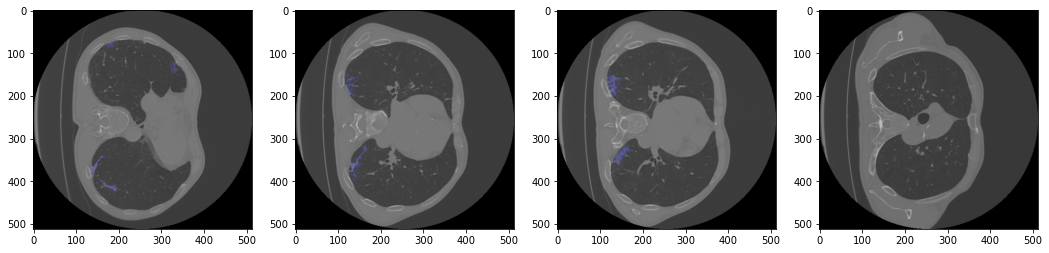

In [12]:
patient_num = 10
slices_num = (10, 19, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_train[sum(forms[:patient_num]) + idx],
        labels_train[sum(forms[:patient_num]) + idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [13]:
# standardize
scaler = StandardScaler()
images_train_std = []
for i in range(len(images_train)):
    images_train_std.append(scaler.fit_transform(images_train[i]))
del images_train
images_train_std = np.array(images_train_std, dtype = 'float32')
labels_train = np.array(labels_train, dtype = 'float32')

In [14]:
slices_all = np.expand_dims(images_train_std, axis = -1)
del images_train_std
labels_all = np.expand_dims(labels_train, axis = -1)
del labels_train

In [15]:
def data_split(indexes, val_split, slices, labels):
    slices_train = []
    labels_train = []
    val_slices = []
    val_labels = []
    
    val_num = int(len(indexes) * val_split)
    for i in range(len(indexes)):
        k = indexes[i]
        if i < val_num:
            val_slices.append(slices_all[k])
            val_labels.append(labels_all[k])
        else:
            slices_train.append(slices_all[k])
            labels_train.append(labels_all[k])
        
    slices_train = np.array(slices_train, dtype = 'float32')
    labels_train = np.array(labels_train, dtype = 'float32')
    val_slices = np.array(val_slices, dtype = 'float32')
    val_labels = np.array(val_labels, dtype = 'float32')
    return slices_train, labels_train, (val_slices, val_labels)

In [16]:
def get_augs(images, masks, treshold = 0, rot = 1):
    images_new = []
    masks_new = []
    for i in range(len(images)):
        if np.sum(masks[i]) > threshold:
            images_new.append(cv2.flip(images[i], rot))
            masks_new.append(cv2.flip(masks[i], rot))

            images_new.append(cv2.rotate(images[i], cv2.cv2.ROTATE_90_CLOCKWISE))
            masks_new.append(cv2.rotate(masks[i], cv2.cv2.ROTATE_90_CLOCKWISE))
            
#             images_new.append(cv2.rotate(images[i], cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
#             masks_new.append(cv2.rotate(masks[i], cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))

    images_new = np.array(images_new, dtype = 'float32')
    masks_new = np.array(masks_new, dtype = 'float32')
    return images_new, masks_new

In [18]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-6,
    decay_steps = 2147,
    decay_rate = 0.9773531112
)

opt = Adam(lr_schedule)
model_checkpoint = ModelCheckpoint('AttNetv3_weights.h5', monitor='val_loss',save_best_only=True)
model = AttentionUnet(512)
model.compile(optimizer = opt, loss = dice_coef_loss, metrics = [dice_coef, f1_m, precision_m, recall_m])
# model.summary() # 14,226,817

In [19]:
indexes = np.array([i for i in range(len(slices_all))])
seed = 123
np.random.seed(seed)
np.random.shuffle(indexes)

In [20]:
val_split = 0.25
slices_train, labels_train, val_data = data_split(indexes, val_split, slices_all, labels_all)
del slices_all, labels_all

In [21]:
threshold = 2
slices_aug, labels_aug = get_augs(slices_train, labels_train, threshold)

slices_aug = np.expand_dims(slices_aug, axis = -1)
labels_aug = np.expand_dims(labels_aug, axis = -1)
slices_train = np.concatenate((slices_train, slices_aug))
labels_train = np.concatenate((labels_train, labels_aug))
del slices_aug, labels_aug

In [22]:
hist = model.fit(slices_train, labels_train,
                    batch_size = 1,
                    validation_data = val_data,
                    epochs = 200,
                    callbacks = [model_checkpoint],
                    shuffle = True,
                    verbose = 1)

Epoch 1/10
2147/2147 [==============================] - 260s 117ms/step - loss: -0.0153 - dice_coef: 0.0153 - f1_m: 0.0249 - precision_m: 0.0133 - recall_m: 0.4605 - val_loss: -0.0250 - val_dice_coef: 0.0250 - val_f1_m: 0.0726 - val_precision_m: 0.0502 - val_recall_m: 0.2445
Epoch 2/10
2147/2147 [==============================] - 248s 116ms/step - loss: -0.0559 - dice_coef: 0.0559 - f1_m: 0.1311 - precision_m: 0.0851 - recall_m: 0.5247 - val_loss: -0.0312 - val_dice_coef: 0.0312 - val_f1_m: 0.1170 - val_precision_m: 0.1102 - val_recall_m: 0.1842
Epoch 3/10
2147/2147 [==============================] - 248s 116ms/step - loss: -0.0765 - dice_coef: 0.0765 - f1_m: 0.1895 - precision_m: 0.1372 - recall_m: 0.5092 - val_loss: -0.0411 - val_dice_coef: 0.0411 - val_f1_m: 0.1371 - val_precision_m: 0.1287 - val_recall_m: 0.2165
Epoch 4/10
2147/2147 [==============================] - 248s 116ms/step - loss: -0.0929 - dice_coef: 0.0929 - f1_m: 0.2247 - precision_m: 0.1696 - recall_m: 0.5301 - val_lo

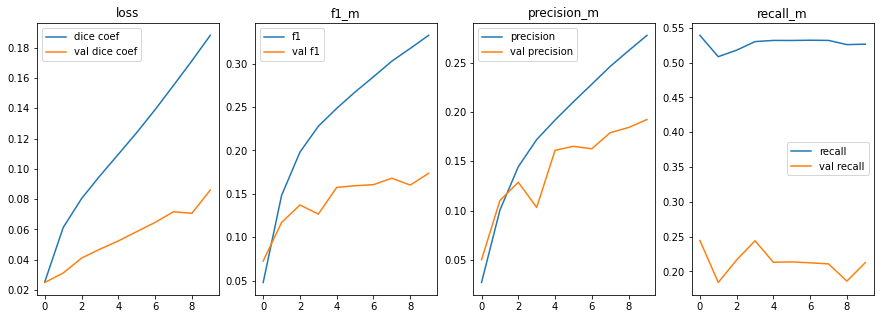

In [23]:
del slices_train, labels_train
show_history(hist)

In [ ]:
model.load_weights("../input/AResNetv3-weights/AResNetv3_weights10.h5")

Посмотрим, что получилось:

In [ ]:
# without deep supervision

labels_pred = []

for i in tqdm(range(len(images_train_std))):
    label_got = model.predict(np.expand_dims(images_train_std[i], 0))
    label = np.squeeze(np.array(label_got))
    labels_pred.append(label)
labels_pred = np.array(labels_pred, dtype = 'float32')

In [ ]:
patient_num = 10
slices_num = (10, 19, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_train[sum(forms[:patient_num]) + idx],
        labels_pred[sum(forms[:patient_num]) + idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:
smooth = 1
dice_sum = 0
summ = 0
for i in tqdm(range(len(images_train_std))):
    dice_sum += dice_coef(K.constant(labels_train[i]), K.constant(labels_pred[i]))
    summ += np.sum(labels_pred[i])
print(summ, np.sum(labels_train))

In [ ]:
# 0.022879237 на unet_128_20_2
# 0.60014623  на unet_128_100_4_0.2
# 0.59323573  на unet_128_200_4_0.2
# 0.60985804  на nested_unetv1_128_20_4_0.2
# 0.7387421   на nested_unetv1_128_100_4_0.2 (bad metric)
# 0.65091836  на nested_unetv1_128_200_4_0.2
# 0.78734815  на nested_unetv2_256_200_8_0.25
# 0.7903303   на nested_unet256v2_213_8_0.25
# 0.7958323   на nested_unet256v2_246_8_0.25
# 0.79706955  на nested_unet256v2_250_8_0.25

# 185: 0.10570089, 0.13043283, 0.70226413, 0.29297653, 0.20176004
# 215: 0.123312995, 0.15917768, 0.72082466, 0.49254957, 0.21171527

print(dice_sum / len(images_train_std))

In [ ]:
# dice after resizement
labels_pred_upscaled = images_upscale(labels_pred_resized, (512, 512), verbose = 1)
dice_sum = 0
for i in range(40):
    lab_tr = K.constant(np.array(labels_train[i]).reshape(labels_train[i].shape[0], labels_train[i].shape[1], labels_train[i].shape[2], 1))
    lab_pr = K.constant(np.array(labels_pred_upscaled[i]).reshape(labels_pred_upscaled[i].shape[0], labels_pred_upscaled[i].shape[1], labels_pred_upscaled[i].shape[2], 1))
    dice_sum += dice_coef(lab_tr, lab_pr)
print(dice_sum / 40)

In [ ]:
"""
Load testing data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
"""
with open('testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_test = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path_images, entry['image']))
    images_test.append(image.get_fdata())

In [ ]:
# reshaping and resizing test images
forms_test, images_test_reshaped = images_reshape(images_test)
# images_test_resized = images_resize(images_test_reshaped, (256, 256), verbose = 1)

In [ ]:
scaler = StandardScaler()
images_test_std = []
for i in range(len(images_test_reshaped)):
    images_test_std.append(scaler.fit_transform(images_test_reshaped[i]))
images_test_std = np.array(images_test_std, dtype = 'float32')

In [ ]:
"""
Write your code here

You need to:
 1. Predict labels for CT scans from images list
 2. Store them in the labels_predicted list in form of numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""
labels_test_0 = []
# labels_test_1 = []
# labels_test_2 = []
# labels_test_3 = []

for i in tqdm(range(len(images_test_std))):
    labels_got = model.predict(np.expand_dims(images_test_std[i], 0))
    label_0 = np.squeeze(np.array(labels_got))
#     label_1 = np.squeeze(np.array(labels_got[1]))
#     label_2 = np.squeeze(np.array(labels_got[2]))
#     label_3 = np.squeeze(np.array(labels_got[3]))
    
    labels_test_0.append(label_0)
#     labels_test_1.append(label_1)
#     labels_test_2.append(label_2)
#     labels_test_3.append(label_3)
    
labels_test = np.array(labels_test_0, dtype = 'float32')
# labels_test_1 = np.array(labels_test_1, dtype = 'float32')
# labels_test_2 = np.array(labels_test_2, dtype = 'float32')
# labels_test_3 = np.array(labels_test_3, dtype = 'float32')

In [ ]:
labels_test = (labels_test_0 + labels_test_1 + labels_test_2 + labels_test_3) / 4

In [ ]:
patient_num = 5
slices_num = (17, 18, 23)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_test_reshaped[sum(forms_test[:patient_num]) + idx],
        labels_test[sum(forms_test[:patient_num]) + idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:
def images_reshape_back_a(images, forms):
    images_new = []
    for i in range(len(forms)):
        person_imgs = np.zeros(shape = (512, 512, forms[i]))
        for k in range(forms[i]):
            person_imgs[:,:,k] = images[k + sum(forms[:i])]
        images_new.append(person_imgs)
    return images_new

def images_reshape_back(images, forms):
    images_new = []
    for i in range(len(forms)):
        tmp = np.zeros(shape = (512, 512, forms[i]))
        images_new.append(tmp)
    stun = 0
    for i in range(len(forms)):
        for k in range(forms[i]):
            l = images[stun][:,:]
            l.shape = 512,512
            images_new[i][:,:,k] = l
            stun = stun + 1
    return images_new

In [ ]:
labels_predicted = images_reshape_back(labels_test, forms_test)

In [ ]:
for i in range(len(labels_predicted)):
    labels_predicted[i] = np.round(labels_predicted[i])

In [ ]:
summ = 0
for i in range(len(labels_predicted)):
    summ += np.sum(labels_predicted[i])
    print(labels_predicted[i].shape, forms_test[i])
print(summ)

In [ ]:
arr = (labels_test_3 > 0.5) * 1.
# arr.shape = 398,512,512,1
mmax = 0
ind = 0
for i in range(len(arr)):
    if (np.sum(arr[i]) > mmax):
        ind = i
        mmax = np.sum(arr[i])

print(ind)
plt.imshow(labels_test_3[ind][:,:])

In [ ]:
patient_num = 5
slices_num = (17, 19, 23)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_test[patient_num][..., idx],
        labels_predicted[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open("submission.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, patient in tqdm(enumerate(labels_predicted)):
        submission_writer.writerow([
                f"{idx}",
                " ".join(rle_encoding(patient))
            ])

Unet_128_100_4_0.2 - 0.26470 score\
Unet_128_200_4_0.2 - 0.36904 score\
Nested_Unet_128_200_4_0,2 - 0.22147 score\
Nested_Unet_256_200_8_0.25 - 0.51621 score\
Nested_Unet_256_213_8_0.25 - 0.51820 score\